# Reading FORTRAN generated binary output
## NCODA Pre-QC

Includes references to plotting using Matplotlib and related tools.

This program reads in a single input file after definine a binary "struct" with which to read in the data.

In [1]:
#Establish setup for graphics, appropriate for jupyter lab
%matplotlib inline
#use nbagg for interactivity
#%matplotlib nbagg

In [2]:
############################################
# INCLUDES
############################################
#libraries specific to this example
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression

#plotting
import matplotlib as matplt
import matplotlib.pyplot as plt
#geographic libraries
from cartopy import crs as ccrs

#byte manipulation and endianess
import sys

# for NetCDF output
from scipy.io import netcdf

#a set of libraries that perhaps should always be in Python source
import os 
from datetime import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

In [3]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "NCODA_PREQC"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################


############################################
# APPLICATION VARIABLES
############################################

#variable persistence
today = datetime.today()

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


# Example of Defining a Function

In [5]:
def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))

    return

# Library Invocation
### Note that it's also useful to use this code so that you carry around a list of version dependencies and know how you did something (version)

In [6]:
lib_diagnostics()

[2022-09-12 10:00:02 CDT]   DEBUG: System version    #:3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0] 
[2022-09-12 10:00:02 CDT]   DEBUG: Matplotlib version#:       3.4.2 
[2022-09-12 10:00:02 CDT]   DEBUG: Numpy version     #:      1.21.1 
[2022-09-12 10:00:02 CDT]   DEBUG: Pandas version    #:       1.3.1 
[2022-09-12 10:00:02 CDT]   DEBUG: SciPy version     #:       1.7.1 


# GOPS Parser Slice Output

In [7]:
#################################################################################
#CONSTANTS
#################################################################################   

#Notice that this is a 300 MB binary file which is NOT included in these training sets.
DATA_DIR=Path("."+os.sep+"data")

#NRL employees
#DATA_DIR=Path("/u/yamm/cwood/outgoing/VISOR")

DATA_FILE=["merged.2020032.0201.L5.6D.a_490_lmi.nc_202001270400_a_490_lmi_2.out"]

#each record in FORTRAN "bounded" by a value that specifies how big the next block to read is hence the RB or record boundary value
FORTRAN_RB_CHUNK_SIZE=4

#expressly defining data types as the original FORTRAN implementation is specific as well
FORTRAN_INT_CHUNK_SIZE=4
FORTRAN_REAL_CHUNK_SIZE=4
DATA_CHUNK=0
ENDIANESS='big'

#Data formatting (least significant digit)
LSD=4

#Geospatial filter criteria, known for this specific data file (Gulf of Mexico)
FLTR_NW_LAT=31.0519
FLTR_NW_LON=-98.4798
FLTR_SE_LAT=19.2310
FLTR_SE_LON=-80.9669
FLTR_DATA = ("lat > " + str(FLTR_SE_LAT) + " & lat < " + str(FLTR_NW_LAT) + " & lon > " + str(FLTR_NW_LON) + " & lon < " + str(FLTR_SE_LON) )

#define data structure of the NCODA-PreQC/VISOR output
preQC_datatype=np.dtype([('frb_nrec1', '>i4'),
                         ('nrec','>i4'),
                         ('frb_nrec2', '>i4'),
                         ('frb_dtype1', '>i4'),
                         ('dtype','>i4'),
                         ('frb_dtype2', '>i4'),
                         ('frb_dtg1', '>i4'),
                         ('dtg','>a12'),
                         ('frb_dtg2', '>i4')
                        ])

In [8]:
#################################################################################
#Mapping routines to show where data resides (leaves much to be desired and
#doesn't make use of 008_mapping*.ipynb.
#################################################################################   
def show_map_coverage(inc_dataframe):

    TARGET_DATAFRAME = inc_dataframe

    central_longitude = np.median(TARGET_DATAFRAME["lon"])
    central_latitude = np.median(TARGET_DATAFRAME["lat"])
    west = np.min(TARGET_DATAFRAME["lon"]) - 1.5
    east = np.max(TARGET_DATAFRAME["lon"]) + 1.5
    north = np.max(TARGET_DATAFRAME["lat"]) + 1.5
    south = np.min(TARGET_DATAFRAME["lat"]) - 1.5

    #matplt.use('Agg')
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([west, east, south, north])
    ax.coastlines()
    ax.stock_img()
    ax.gridlines()
    ax.add_wms(wms="http://vmap0.tiles.osgeo.org/wms/vmap0", layers=["basic"])

    DATA_COLOR = "red"
    DATA_SIZE = 0.10 
    ax.scatter(TARGET_DATAFRAME["lon"], TARGET_DATAFRAME["lat"], c=DATA_COLOR, s=DATA_SIZE)

    #output_filename=PROJ_OUTPUT_LOC / str( build_output_graphic_filename(inc_area,inc_date,inc_depth_index)+str("_") + inc_name+("_map.png") )
    #debug.msg_debug("Graphics output filename:"+str(output_filename))
    #plt.savefig(output_filename)
    
    plt.show()
    plt.close()



[2022-09-12 10:00:05 CDT]   DEBUG: Processing 202001270400a for data/merged.2020032.0201.L5.6D.a_490_lmi.nc_202001270400_a_490_lmi_2.out 
[2022-09-12 10:00:05 CDT]   DEBUG: [(4, 26154810, 4, 4, 219, 4, 12, b'202001270400', 12)] 
[2022-09-12 10:00:05 CDT]   DEBUG: Total records to read in for each array:26154810 
[2022-09-12 10:00:05 CDT]   DEBUG: Total bytes to read in for each array:[104619240] 
[2022-09-12 10:00:05 CDT]    INFO: ...processing lat data from PreQC 
[2022-09-12 10:00:07 CDT]   DEBUG: ......statistics: 
[2022-09-12 10:00:07 CDT]   DEBUG: .........min:-74.99 
[2022-09-12 10:00:07 CDT]   DEBUG: .........max:50.31 
[2022-09-12 10:00:07 CDT]   DEBUG: ........mean:-12.222337 
[2022-09-12 10:00:07 CDT]   DEBUG: Lat size:26154810 
[2022-09-12 10:00:07 CDT]    INFO: ...processing lon data from PreQC 
[2022-09-12 10:00:09 CDT]   DEBUG: ......statistics: 
[2022-09-12 10:00:09 CDT]   DEBUG: .........min:-100.0 
[2022-09-12 10:00:09 CDT]   DEBUG: .........max:-60.01 
[2022-09-12 10:

ImportError: OWSLib is required to use OGC web services.

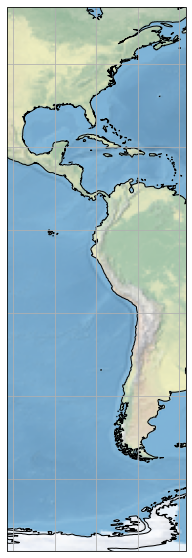

In [9]:
#loop through the datafiles provided
for file in DATA_FILE:
    target_input_file=Path(DATA_DIR / file)
    netcdf_filename=Path(DATA_DIR / str(file + ".nc") )
    
    #meta-data capture from filename (merged_2019317_201911130400_a_490_lmi_2)
    file_meta_data = file.split('_')
    product_name="".join(file_meta_data[3:5:1])
    debug.msg_debug("Processing " + str(product_name) + " for "+ str(target_input_file))

    in_file=open(target_input_file, 'rb')
    
    #################################################################################
    #Binary read using the pre-defined structure
    #################################################################################    
    x=np.fromfile(in_file, dtype=preQC_datatype,count=1)
    DATA_CHUNK= FORTRAN_REAL_CHUNK_SIZE * x['nrec']
    debug.msg_debug(x)
    debug.msg_debug("Total records to read in for each array:"+str(x['nrec'][0]))
    debug.msg_debug("Total bytes to read in for each array:"+str(DATA_CHUNK))
    
    number_records=str(x['nrec'][0])
    array_structure=">"+ number_records +"f4"
    array_dtype=np.dtype([('frb_ary1', '>i4'),('array',array_structure),('frb_ary2', '>i4')])

    debug.msg_info("...processing lat data from PreQC")
    y=np.fromfile(in_file, dtype=array_dtype,count=1)
    array=y['array']
    debug.msg_debug("......statistics:")
    debug.msg_debug(".........min:" + str(np.nanmin(array)))
    debug.msg_debug(".........max:" + str(np.nanmax(array)))
    debug.msg_debug("........mean:" + str(np.nanmean(array)))
    lat=np.array(array).byteswap().newbyteorder()
    debug.msg_debug("Lat size:"+str(lat.size))
    
    debug.msg_info("...processing lon data from PreQC")
    y=np.fromfile(in_file, dtype=array_dtype,count=1)
    array=y['array']
    debug.msg_debug("......statistics:")
    debug.msg_debug(".........min:" + str(np.nanmin(array)))
    debug.msg_debug(".........max:" + str(np.nanmax(array)))
    debug.msg_debug("........mean:" + str(np.nanmean(array)))
    lon=np.array(array).byteswap().newbyteorder()
    debug.msg_debug("Lon size:"+str(lon.size))

    debug.msg_info("...processing optics data from PreQC")
    y=np.fromfile(in_file, dtype=array_dtype,count=1)
    array=y['array']
    debug.msg_debug("......statistics:")
    debug.msg_debug(".........min:" + str(np.nanmin(array)))
    debug.msg_debug(".........max:" + str(np.nanmax(array)))
    debug.msg_debug("........mean:" + str(np.nanmean(array)))
    optics=np.array(array).byteswap().newbyteorder()
    debug.msg_debug("Optics size:"+str(optics.size))
    
    #################################################################################
    #casting data-types from float 32 to int64 to support .query operation
    #################################################################################    
    df=pd.DataFrame({'lat':lat[0,:], 'lon':lon[0,:], 'optics':optics[0,:]})
    lat=df['lat']
    df['lat'] = lat.astype('float', copy=True)
    lon=df['lon']
    df['lon'] = lon.astype('float', copy=True)
    optics=df['optics']
    df['optics'] = optics.astype('float', copy=True)
    
    #################################################################################
    #Pandas, filtering data down to focal area
    #################################################################################    
    GOMEX=df.query(FLTR_DATA)

    #################################################################################
    #Debug output showing data reduction due to the filter
    #################################################################################    
    debug.msg_debug("Original dataset shape:"+ str(df.shape))
    debug.msg_debug("   GOMEX dataset shape:"+ str(GOMEX.shape))
    debug.msg_debug("   GOMEX lat dimension:" + str(GOMEX['lat'].size))
    debug.msg_debug("   GOMEX lon dimension:" + str(GOMEX['lon'].size))

    #################################################################################
    #Create a map showing the total swath of the output
    #################################################################################    
    show_map_coverage(df)
    #################################################################################
    #Create a map showing the filtered data set and focal point of analysis
    #################################################################################    
    show_map_coverage(GOMEX)

    #################################################################################
    #Clean up unused variables
    #################################################################################    
    del x
    del array
    del lat
    del lon
    del optics
    del df    
   
    #################################################################################
    # NetCDF build after marshaling data.
    #################################################################################    
    inc_lat_dim = GOMEX['lat'].size
    inc_lon_dim = GOMEX['lon'].size  
    
    #close data file read in
    in_file.close()

    #################################################################################
    #NetCDF global attributes
    #################################################################################    
    dataset = netcdf.netcdf_file(netcdf_filename, "w")
    meta_data_input="Visible Band Satellite Data to Improve Ocean Model Radiative Transfer (VISOR)"
    dataset.title = meta_data_input.encode(ENCODING, errors='ignore').strip()
    meta_data_input="Test validation for " + str(file)
    dataset.subtitle = meta_data_input.encode(ENCODING, errors='ignore')
    meta_data_input="Created with Jupyter Lab, NetCDF4 libraries, GOPS VISOR Parser input file."
    dataset.description = meta_data_input.encode(ENCODING, errors='ignore')
    meta_data_input="Created " + today.strftime("%d/%m/%y")
    dataset.history = meta_data_input.encode(ENCODING, errors='ignore')


    #################################################################################
    #NetCDF dimension declaration
    #################################################################################    
    lat_dim = dataset.createDimension("lat", inc_lat_dim)
    lon_dim = dataset.createDimension("lon", inc_lon_dim)
    optics_dim = dataset.createDimension("optics", inc_lon_dim)
    x_dim = dataset.createDimension("x", inc_lat_dim)
    y_dim = dataset.createDimension("y", inc_lon_dim)

 
    #NetCDF Variable creation and data assignment
    #################################################################################
    # Latitude
    #################################################################################    
    lat_reference = dataset.createVariable("lat", "f8", ("lat",))
    lat_reference.units="degrees north"
    lat_reference[:] = GOMEX['lat']
    
    #################################################################################
    # Longitude
    #################################################################################    
    lon_reference = dataset.createVariable("lon", "f8", ("lon",))
    lon_reference.units="degrees east"
    lon_reference[:] = GOMEX['lon']
    
    #################################################################################
    # Optics Data
    #################################################################################    
    optics_reference = dataset.createVariable("optics", "f8", ("optics",))
    optics_reference[:] = GOMEX['optics']
    optics_reference.units="m^-1"
    optics_reference.warning = str(product_name) + " generated from GOPS Parser, originated from GOPS processing system."

    dataset.close()
    debug.msg_info(" ")
    debug.msg_info("#####################################################################################################################")